In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from modules.BatchPitNormalization import BatchPitNorm1d
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")


Using cuda device


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = np.genfromtxt('data/housing.csv', delimiter=",",skip_header=1)

data = np.delete(data, [-1], axis=1)


X = data[:,:8]
Y = data[:,8].reshape(-1,1)



Y=Y[~np.isnan(X).any(axis=1)]
X=X[~np.isnan(X).any(axis=1)]

print(np.mean(Y))

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, shuffle = True)

scalerX = StandardScaler()
scalerY = StandardScaler()
# scale
scaler_x = scalerX.fit(X_train_raw)
scaler_y = scalerY.fit(y_train_raw)

X_train = scaler_x.transform(X_train_raw)
X_test = scaler_x.transform(X_test_raw)


y_train = scaler_y.transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device).reshape(-1,1)



206864.41315519012


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
#baseline with ordinary least squares Linear Regression
X_train_bl = X_train.detach().cpu().numpy()
Y_train_bl = y_train.detach().cpu().numpy()
x_test_bl = X_test.detach().cpu().numpy()
y_test_bl = y_test.detach().cpu().numpy()
reg = LinearRegression().fit(X_train_bl, Y_train_bl)
reg.score(X_train_bl,Y_train_bl)
y_pred_bl = reg.predict(x_test_bl)
y_pred_bl = scaler_y.inverse_transform(y_pred_bl)
y_test_bl = scaler_y.inverse_transform(y_test_bl)
print("R2-score: ", r2_score(y_test_bl,y_pred_bl))
print("MAE:", mean_absolute_error(y_test_bl,y_pred_bl))
print("RMSE:", root_mean_squared_error(y_test_bl,y_pred_bl))

R2-score:  0.6422813443338331
MAE: 50406.242
RMSE: 69093.836


In [54]:
#without bn
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [55]:
#with bn on first
class NeuralNetwork2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            #nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [56]:
# with 2 bn on first two layers
class NeuralNetwork3(nn.Module):
    def __init__(self, input_size:int, hidden_size:int, num_classes:int):
        super(NeuralNetwork3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x


In [57]:
# with  3 bn
class NeuralNetwork4(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork4, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [58]:
# with batch pit
class NeuralNetwork5(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork5, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=hidden_size*3,dev=device,take_num_samples_when_full=0),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            #BatchPitNorm1d(num_features=hidden_size,num_pit_samples=hidden_size*3,dev=device,take_num_samples_when_full=0),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [59]:
def get_train_test_data(X,Y):
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, shuffle = True)
    #scalers
    scaler_x = StandardScaler().fit(X_train_raw)
    scaler_y = StandardScaler().fit(y_train_raw)

    #scale data
    X_train = scaler_x.transform(X_train_raw)
    X_test = scaler_x.transform(X_test_raw)
    y_train = scaler_y.transform(y_train_raw)
    y_test = scaler_y.transform(y_test_raw)
    #make tensors
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1,1)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device).reshape(-1,1)

    return X_train, y_train, X_test, y_test, scaler_x, scaler_y

In [66]:
def train_model(NN):
    X_train,y_train,X_test,y_test, scaler_x,scaler_y = get_train_test_data(X,Y)
    input_size = 8
    hidden_size = 32
    num_classes = 1
    learning_rate = 0.001 
    n_epochs = 30 
    batch_size = 128

    model = NN(input_size, hidden_size, num_classes).to(device)
    model.cuda()
    lossFunction = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=batch_size)
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for Xbatch, ybatch in loader:
            
            y_pred = model(Xbatch)
            loss = lossFunction(y_pred, ybatch)
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()

    model.eval()
    y_pred_eval = model(X_test)
    y_pred_eval = y_pred_eval.detach().cpu().numpy()
    y_pred_scaled = scaler_y.inverse_transform(y_pred_eval)
    y_test_eval = y_test.detach().cpu().numpy()
    y_test_scaled = scaler_y.inverse_transform(y_test_eval)
    r2 = r2_score(y_test_scaled,y_pred_scaled)
    mae = mean_absolute_error(y_test_scaled,y_pred_scaled)
    rmse = root_mean_squared_error(y_test_scaled,y_pred_scaled)
    #print("R2-score: ",r2)
    #print("MAE: ", mae)
    #print("RMSE: ", rmse)
    return r2, mae,rmse

In [67]:
R2_list = []
MAE_list = []
RMSE_list = []
R2_list_bn = []
MAE_list_bn = []
RMSE_list_bn = []
R2_list_pit = []
MAE_list_pit = []
RMSE_list_pit = []

for i in range(5):

    r2,mae,rmse = train_model(NeuralNetwork)
    r2_bn,mae_bn,rmse_bn = train_model(NeuralNetwork2)
    R2_pit,mae_pit,rmse_pit = train_model(NeuralNetwork5)
    # no bn
    R2_list.append(r2)
    MAE_list.append(mae)
    RMSE_list.append(rmse)
    # ordinary bn
    R2_list_bn.append(r2_bn)
    MAE_list_bn.append(mae_bn)
    RMSE_list_bn.append(rmse_bn)
    # pit
    R2_list_pit.append(R2_pit)
    MAE_list_pit.append(mae_pit)
    RMSE_list_pit.append(rmse_pit)



/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q25 = torch.quantile(input=data, q=.25, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:104: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q75 = torch.quantile(input=data, q=.75, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: Us

Text(0.5, 1.0, 'RMSE')

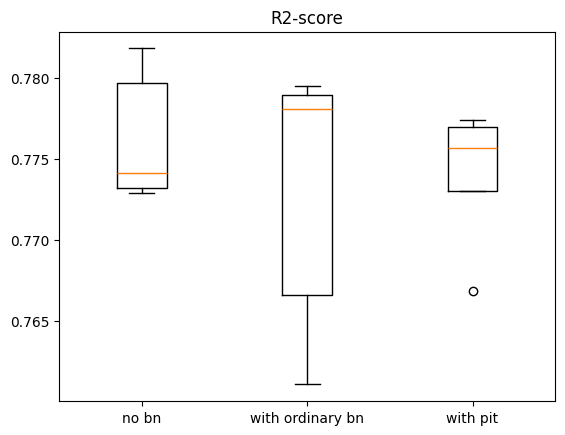

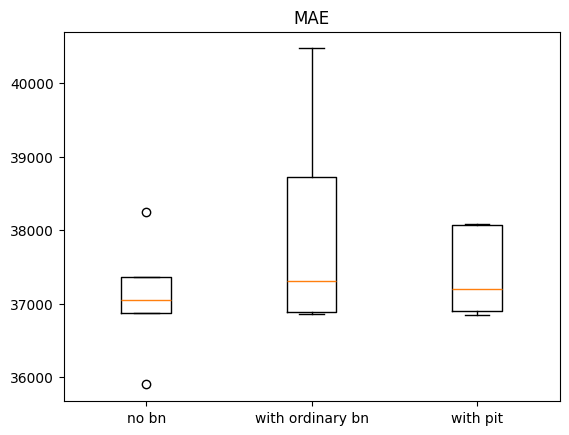

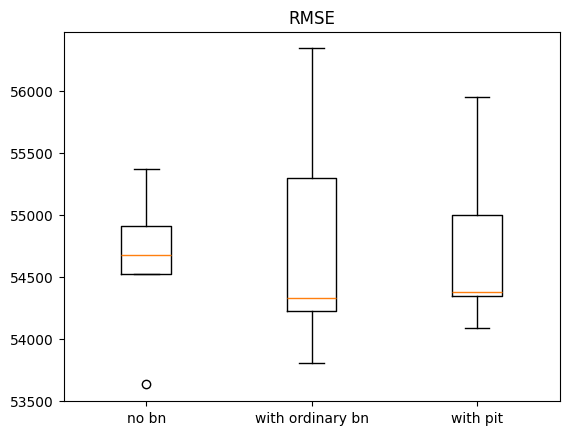

In [68]:
plt.boxplot([R2_list,R2_list_bn,R2_list_pit],labels=["no bn","with ordinary bn", "with pit"])
plt.title("R2-score")
plt.figure()
plt.boxplot([MAE_list,MAE_list_bn,MAE_list_pit],labels=["no bn","with ordinary bn", "with pit"])
plt.title("MAE")
plt.figure()
plt.boxplot([RMSE_list,RMSE_list_bn,RMSE_list_pit],labels=["no bn","with ordinary bn", "with pit"])
plt.title("RMSE")